In [55]:
from tqdm.notebook import tqdm
from numba import  jit,f8,i8,prange
import numpy as np

In [30]:
@jit(nopython=True)
def roll_1(A,B):
    B = B%A.shape[1]
    return np.hstack((A[:,-B:],A[:,:-B]))

@jit(nopython=True)
def roll_0(A,B):
    B = B%A.shape[0]
    return np.vstack((A[-B:,:],A[:-B,:]))

@jit(nopython=True)
def meshgrid(x,y):
    return x_mesh(x,y),y_mesh(x,y)

@jit(nopython=True)
def x_mesh(x,y):
    res = np.zeros((int(y.shape[0]),int(x.shape[0])))
    for i in range(int(y.shape[0])):
        res[i]=x
    return res

@jit(nopython=True)
def y_mesh(x,y):
    res = np.zeros((y.shape[0],x.shape[0]))
    for i in range(int(x.shape[0])):
        res[:,i]=y
    return res  

In [28]:
%timeit x_mesh(np.arange(5,10),np.arange(15,18))

1.4 µs ± 7.64 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [31]:
@jit(nopython=True)
def mesh2(x,y):
    res = np.zeros((2,int(y.shape[0]),int(x.shape[0])))
    for i in range(int(y.shape[0])):
        res[0,i]=x
        res[1,i]=np.repeat(y[i],int(x.shape[0]))
    return res[0],res[1]

In [15]:
meshgrid(np.arange(5,10),np.arange(15,18))

(array([[5., 6., 7., 8., 9.],
        [5., 6., 7., 8., 9.],
        [5., 6., 7., 8., 9.]]),
 array([[15., 15., 15., 15., 15.],
        [16., 16., 16., 16., 16.],
        [17., 17., 17., 17., 17.]]))

In [46]:
m = np.random.rand(3,5)
%timeit roll_1(m,5)
%timeit np.roll(m,5,axis=1)

485 ns ± 4.88 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
8.47 µs ± 803 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [63]:
def solve():
    """
    Create Your Own Lattice Boltzmann Simulation (With Python)
    Philip Mocz (2020) Princeton Univeristy, @PMocz
    Simulate flow past cylinder
    for an isothermal fluid
    """
    
    # Simulation parameters
    Nx                     = 400    # resolution x-dir
    Ny                     = 100    # resolution y-dir
    rho0                   = 100    # average density
    tau                    = 0.6    # collision timescale
    Nt                     = 4000   # number of timesteps
    
    res = np.zeros((Nt,Ny,Nx),dtype=np.float)
    
    
    NL = 9
    idxs = np.arange(NL)
    cxs = np.array([0, 0, 1, 1, 1, 0,-1,-1,-1])
    cys = np.array([0, 1, 1, 0,-1,-1,-1, 0, 1])
    weights = np.array([4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36]) # sums to 1

    F = np.ones((Ny,Nx,NL)) #* rho0 / NL
    np.random.seed(42)
    F += 0.01*np.random.randn(Ny,Nx,NL)
    X, Y = np.meshgrid(range(Nx), range(Ny))
    F[:,:,3] += 2 * (1+0.2*np.cos(2*np.pi*X/Nx*4))
    rho = np.sum(F,2)
    for i in idxs:
        F[:,:,i] *= rho0 / rho

    X, Y = np.meshgrid(range(Nx), range(Ny))
    cylinder = (X - Nx/4)**2 + (Y - Ny/2)**2 < (Ny/4)**2

#     fig = plt.figure(figsize=(4,2), dpi=80)


    for it in tqdm(range(Nt)):

        for i, cx, cy in zip(idxs, cxs, cys):
            F[:,:,i] = np.roll(F[:,:,i], cx, axis=1)
            F[:,:,i] = np.roll(F[:,:,i], cy, axis=0)


        bndryF = F[cylinder,:]
        bndryF = bndryF[:,[0,5,6,7,8,1,2,3,4]]


        rho = np.sum(F,2)
        ux  = np.sum(F*cxs,2) / rho
        uy  = np.sum(F*cys,2) / rho


        Feq = np.zeros(F.shape)
        for i, cx, cy, w in zip(idxs, cxs, cys, weights):
            Feq[:,:,i] = rho * w * ( 1 + 3*(cx*ux+cy*uy)  + 9*(cx*ux+cy*uy)**2/2 - 3*(ux**2+uy**2)/2 )

        F += -(1.0/tau) * (F - Feq)

        F[cylinder,:] = bndryF

        ux[cylinder] = 0
        uy[cylinder] = 0
        vorticity = (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) - (np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1))
        vorticity[cylinder] = 0
        
        res[it] = vorticity
        
    return res




res= solve()

  0%|          | 0/4000 [00:00<?, ?it/s]

In [64]:
import numpy as np
from tqdm.notebook import tqdm 
import numpy as np
import os
import h5py

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
import tensorflow


from datetime import datetime
import time
# import sklearn
# import sklearn.metrics

def conv(x,f,k):
    x = TimeDistributed(Conv2D(f,(k,k),strides=1,padding='same',kernel_initializer='glorot_uniform',activation=LeakyReLU()))(x)
    return x
    
def deconv(x,f,k):
    x = TimeDistributed(Conv2DTranspose(f,(k,k),strides=1,padding='same',kernel_initializer='glorot_uniform',activation=LeakyReLU()))(x)
    return x
    
    
def dense_block(tensor, f, r,k):
    for _ in range(r):
        x = conv(tensor, f=4*f, k=1)
        x = conv(x, f=f, k=k)
        tensor = Concatenate()([tensor, x])
    return tensor

def inv_dense_block(tensor, f, r,k):
    for _ in range(r):
        x = deconv(tensor, f=4*f, k=1)
        x = deconv(x, f=f, k=k)
        tensor = Concatenate()([tensor, x])
    return tensor

def transition(x,s):
    ff = int(tensorflow.keras.backend.int_shape(x)[-1] * 0.5)
    m0 = TimeDistributed(Conv2D(ff,(1,1),strides=2*s,padding='same',kernel_initializer='glorot_uniform',activation=LeakyReLU()))(x)
    return m0

def inv_transition(x,s):
    ff = int(tensorflow.keras.backend.int_shape(x)[-1] * 0.5)
    m0 = TimeDistributed(Conv2DTranspose(ff,(1,1),strides=2*s,padding='same',kernel_initializer='glorot_uniform',activation=LeakyReLU()))(x)
    return m0


def dfn():
    
    k=3
    s=1;
    LR=1e-4
    
    r1,r2,r3 = 2 , 4 ,8
    f0,f1,f2,f3 = 128,32,32,32
    l1,l2 = 128 ,64

    x = Input(shape=(None, None,None, 1))
    c0 = TimeDistributed(Conv2D(f0,(k,k),strides=1,padding='same',kernel_initializer='glorot_uniform',activation=LeakyReLU()))(x)
########################################################################################################    
    e1 = dense_block(c0,f1,r=r1,k=k);m1 = transition(e1,s)
    e2 = dense_block(m1,f2,r=r2,k=k);m2 = transition(e2,s)
    e3 = dense_block(m2,f3,r=r3,k=k);
########################################################################################################
    e = ConvLSTM2D(l1,(2,2),padding='same',return_sequences=True)(e3)
    b = ConvLSTM2D(l2,(2,2),padding='same',return_sequences=True)(e)
    d = ConvLSTM2D(l1,(2,2),padding='same',return_sequences=True)(b)
########################################################################################################
    d1 = inv_dense_block(d ,f3,r=r3,k=k);m1 = inv_transition(d1,s)
    d2 = inv_dense_block(m1,f2,r=r2,k=k);m2 = inv_transition(d2,s)
    d3 = inv_dense_block(m2,f1,r=r1,k=k);
########################################################################################################
    out = conv(d3,f=1,k=1)
    model = Model(x,out)
    optimizer = Adam(learning_rate=LR)
    model.compile(loss='mae',optimizer=optimizer,metrics=['mse'])
    return model

model = dfn()

In [65]:
from sklearn.model_selection import train_test_split

dt = 500
x = np.zeros((4000-dt,1,100,400,1))
y = np.zeros((4000-dt,1,100,400,1))
for i in tqdm(range(4000-dt )):
    x[i,0,:,:,0] = res[i]
    y[i,0,:,:,0] = res[i+dt]

  0%|          | 0/3500 [00:00<?, ?it/s]

In [66]:
mean,std=np.mean(x),np.std(x)
print(mean,std)

xs = (x-mean)/std ; ys= (y-mean)/std
xx, xxx, yy, yyy = train_test_split(xs, ys, test_size=0.1, random_state=42)

train_data={}
val_data={}
batch_size=8

for i in tqdm(range(xx.shape[0]//batch_size)):
    train_data[i] = {'x':xx[i*batch_size:(i+1)*batch_size],'y':yy[i*batch_size:(i+1)*batch_size]}

for i in tqdm(range(xxx.shape[0]//batch_size)):
    val_data[i] = {'x':xxx[i*batch_size:(i+1)*batch_size],'y':yyy[i*batch_size:(i+1)*batch_size]}

-2.330521030908044e-10 0.016038489933819542


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

In [67]:
def data_generator(data):
    '''
    input : data dictionary (batch number :5D tensor data)
    output: input , target values
    '''
    batches = len(data.keys())
    batch_size = len(data[0])
    batch_counter= 0
    
    while True:
        x,y = data[batch_counter]['x'],data[batch_counter]['y']

        batch_counter += 1
        yield x,y
        if batch_counter == batches:batch_counter = 0

In [68]:
csv_logger = tensorflow.keras.callbacks.CSVLogger('train cylinder.log')
early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='loss',min_delta=5e-5, patience=5, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
reduce_lr_callback = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor = 'loss',factor = 0.5,patience = 3,verbose = 1,cooldown=1,min_delta = 1e-4,min_lr=1e-8 )
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint('cylinder.h5', monitor='loss', verbose=1, save_best_only=False,save_weights_only=False, mode='auto', save_freq='epoch',)
history = model.fit(data_generator(train_data),
          validation_data=data_generator(val_data),
          steps_per_epoch=len(train_data),
          validation_steps=len(val_data),
          verbose=1,
          epochs=100,
          callbacks=[reduce_lr_callback,early_stopping,csv_logger,model_checkpoint_callback],
         )

Epoch 1/100
393/393 [==============================] - 93s 197ms/step - loss: 0.3962 - mse: 0.6955 - val_loss: 0.2348 - val_mse: 0.3359

Epoch 00001: saving model to cylinder.h5
Epoch 2/100
393/393 [==============================] - 75s 192ms/step - loss: 0.2256 - mse: 0.2847 - val_loss: 0.1798 - val_mse: 0.2136

Epoch 00002: saving model to cylinder.h5
Epoch 3/100
393/393 [==============================] - 76s 192ms/step - loss: 0.1644 - mse: 0.1730 - val_loss: 0.1403 - val_mse: 0.1461

Epoch 00003: saving model to cylinder.h5
Epoch 4/100
393/393 [==============================] - 76s 192ms/step - loss: 0.1364 - mse: 0.1251 - val_loss: 0.1213 - val_mse: 0.1109

Epoch 00004: saving model to cylinder.h5
Epoch 5/100
393/393 [==============================] - 76s 192ms/step - loss: 0.1162 - mse: 0.0948 - val_loss: 0.1025 - val_mse: 0.0857

Epoch 00005: saving model to cylinder.h5
Epoch 6/100
393/393 [==============================] - 76s 193ms/step - loss: 0.1020 - mse: 0.0765 - val_loss:

Epoch 47/100
393/393 [==============================] - 76s 192ms/step - loss: 0.0296 - mse: 0.0095 - val_loss: 0.0261 - val_mse: 0.0092

Epoch 00047: saving model to cylinder.h5
Epoch 48/100
393/393 [==============================] - 76s 192ms/step - loss: 0.0287 - mse: 0.0092 - val_loss: 0.0254 - val_mse: 0.0088

Epoch 00048: saving model to cylinder.h5
Epoch 49/100
393/393 [==============================] - 76s 192ms/step - loss: 0.0272 - mse: 0.0086 - val_loss: 0.0261 - val_mse: 0.0094

Epoch 00049: saving model to cylinder.h5
Epoch 50/100
393/393 [==============================] - 76s 193ms/step - loss: 0.0284 - mse: 0.0089 - val_loss: 0.0250 - val_mse: 0.0084

Epoch 00050: saving model to cylinder.h5
Epoch 51/100
393/393 [==============================] - 76s 192ms/step - loss: 0.0265 - mse: 0.0081 - val_loss: 0.0286 - val_mse: 0.0091

Epoch 00051: saving model to cylinder.h5
Epoch 52/100
393/393 [==============================] - 76s 192ms/step - loss: 0.0267 - mse: 0.0080 - val

393/393 [==============================] - 76s 192ms/step - loss: 0.0120 - mse: 0.0027 - val_loss: 0.0126 - val_mse: 0.0030

Epoch 00091: saving model to cylinder.h5
Epoch 92/100
393/393 [==============================] - 76s 193ms/step - loss: 0.0121 - mse: 0.0027 - val_loss: 0.0125 - val_mse: 0.0030

Epoch 00092: saving model to cylinder.h5
Epoch 93/100
393/393 [==============================] - 76s 192ms/step - loss: 0.0121 - mse: 0.0026 - val_loss: 0.0125 - val_mse: 0.0029

Epoch 00093: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00093: saving model to cylinder.h5
Epoch 94/100
393/393 [==============================] - 76s 192ms/step - loss: 0.0117 - mse: 0.0026 - val_loss: 0.0119 - val_mse: 0.0029

Epoch 00094: saving model to cylinder.h5
Epoch 95/100
393/393 [==============================] - 76s 192ms/step - loss: 0.0116 - mse: 0.0026 - val_loss: 0.0119 - val_mse: 0.0029

Epoch 00095: saving model to cylinder.h5
Epoch 96/100
393/393 [================

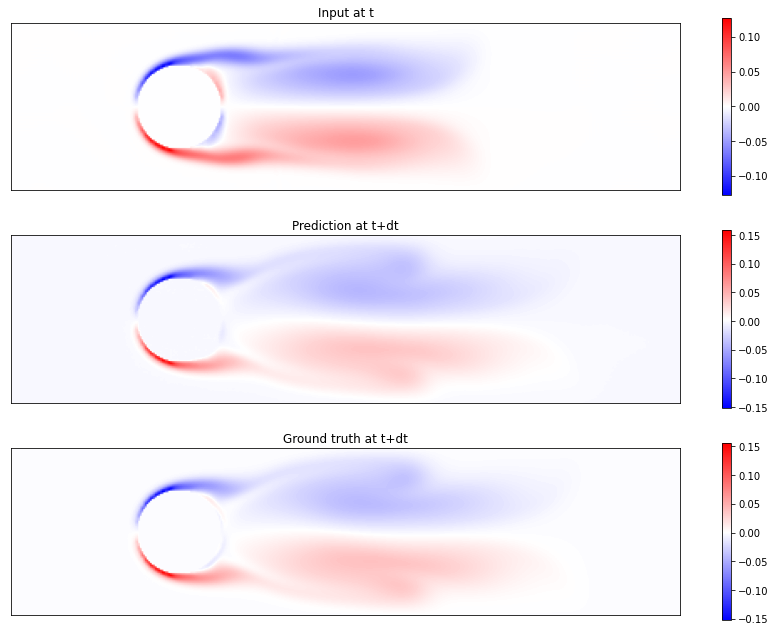

In [99]:
import matplotlib.pyplot as plt
sample = 10
pred =model.predict(xxx[[sample]])
plt.figure(figsize=(15,15))
plt.subplot(4,1,1);plt.imshow((xxx[sample,0,:,:,0]*std)+mean,cmap='bwr');plt.xticks([]);plt.yticks([]);plt.title('Input at t');plt.colorbar()
plt.subplot(4,1,2);plt.imshow((pred[0,0,:,:,0]*std)+mean,cmap='bwr');plt.xticks([]);plt.yticks([]);plt.title('Prediction at t+dt');plt.colorbar()
plt.subplot(4,1,3);plt.imshow((yyy[sample,0,:,:,0]*std)+mean,cmap='bwr');plt.xticks([]);plt.yticks([]);plt.title('Ground truth at t+dt');plt.colorbar()

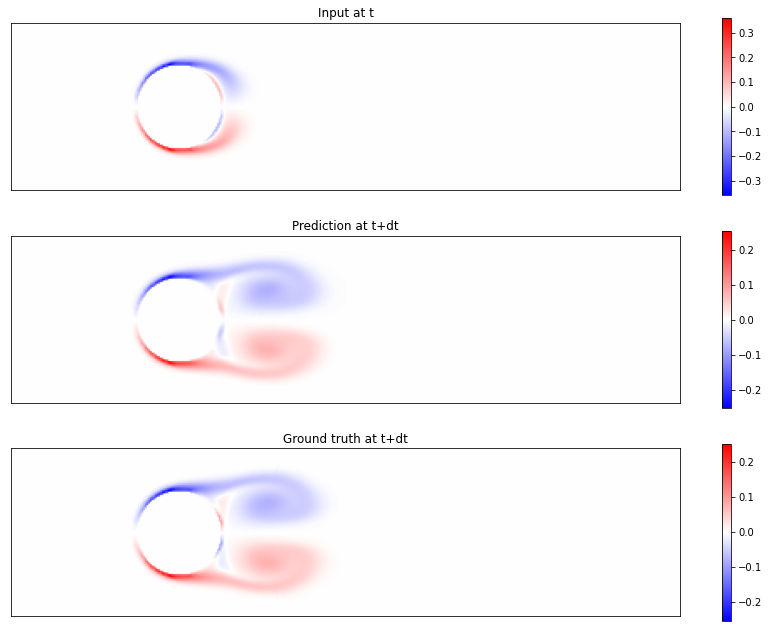

In [100]:
import matplotlib.pyplot as plt
sample = 100
pred =model.predict(xxx[[sample]])
plt.figure(figsize=(15,15))
plt.subplot(4,1,1);plt.imshow((xxx[sample,0,:,:,0]*std)+mean,cmap='bwr');plt.xticks([]);plt.yticks([]);plt.title('Input at t');plt.colorbar()
plt.subplot(4,1,2);plt.imshow((pred[0,0,:,:,0]*std)+mean,cmap='bwr');plt.xticks([]);plt.yticks([]);plt.title('Prediction at t+dt');plt.colorbar()
plt.subplot(4,1,3);plt.imshow((yyy[sample,0,:,:,0]*std)+mean,cmap='bwr');plt.xticks([]);plt.yticks([]);plt.title('Ground truth at t+dt');plt.colorbar()

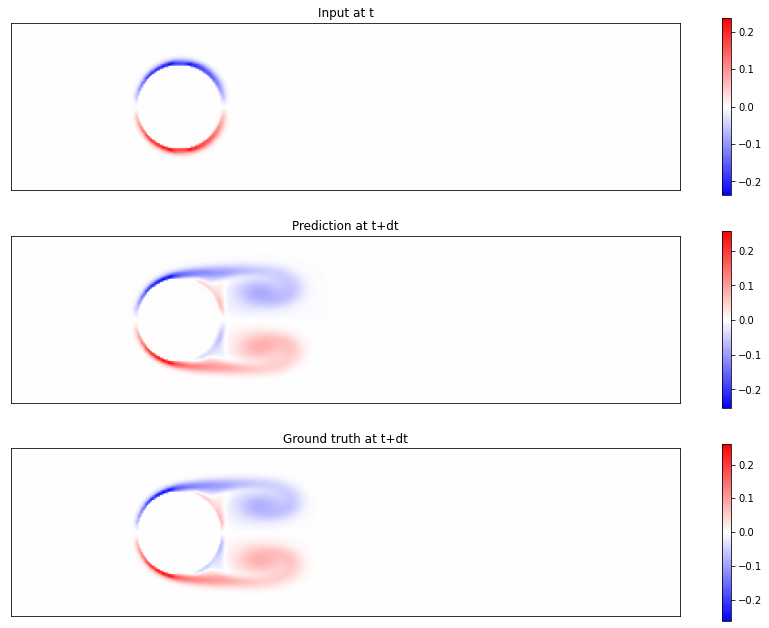

In [101]:
import matplotlib.pyplot as plt
sample = 50
pred =model.predict(xxx[[sample]])
plt.figure(figsize=(15,15))
plt.subplot(4,1,1);plt.imshow((xxx[sample,0,:,:,0]*std)+mean,cmap='bwr');plt.xticks([]);plt.yticks([]);plt.title('Input at t');plt.colorbar()
plt.subplot(4,1,2);plt.imshow((pred[0,0,:,:,0]*std)+mean,cmap='bwr');plt.xticks([]);plt.yticks([]);plt.title('Prediction at t+dt');plt.colorbar()
plt.subplot(4,1,3);plt.imshow((yyy[sample,0,:,:,0]*std)+mean,cmap='bwr');plt.xticks([]);plt.yticks([]);plt.title('Ground truth at t+dt');plt.colorbar()

In [94]:
mean

-2.330521030908044e-10

Text(0, 0.5, 'MAE')

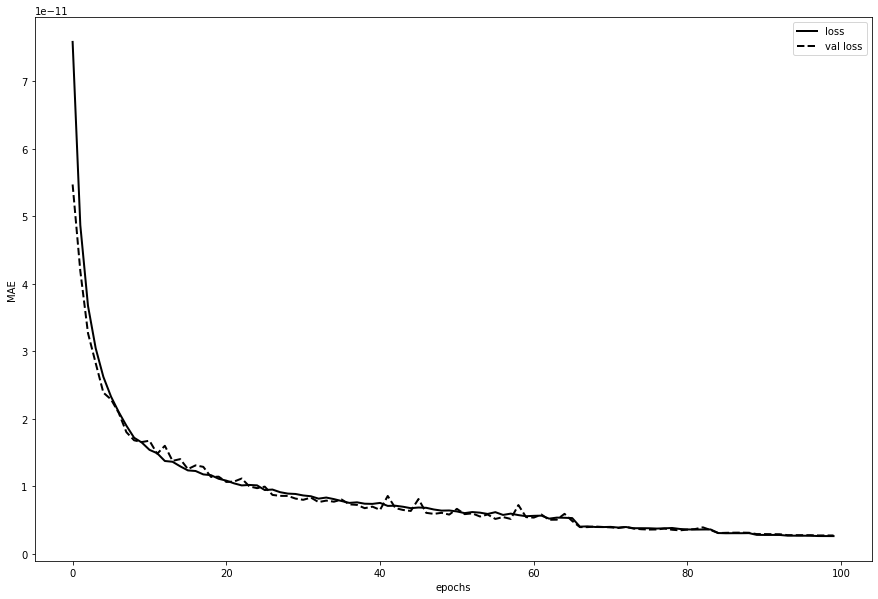

In [96]:
plt.figure(figsize=(15,10))

loss,val_loss = np.array(history.history['loss']) , np.array(history.history['val_loss']) 

plt.plot(np.arange(100),-loss*mean,'-k',linewidth=2)
plt.plot(np.arange(100),-val_loss*mean,'--k',linewidth=2)
plt.legend(['loss','val loss'])
plt.xlabel('epochs')
plt.ylabel('MAE')